In [1]:
'''
BE VERY CAREFUL. Only interior marsh included currently. Lat and lon may be in the predictors. Seems to work well.
'''

'\nBE VERY CAREFUL. Only interior marsh included currently. Lat and lon are in the predictors. Seems to work well.\n'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [4]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [5]:
#ADD: PDSI and Evaporation potential!

'''ADD: LOG and z-score for river discharge! see https://link.springer.com/article/10.1007/s10021-013-9732-6

TALKS ABOUT SITE 8 IN RESULTS. GET SITE BACK IN THERE

ADD SLOPE TOO!!

'''

'ADD: LOG and z-score for river discharge! see https://link.springer.com/article/10.1007/s10021-013-9732-6\n\nTALKS ABOUT SITE 8 IN RESULTS. GET SITE BACK IN THERE\n\nADD SLOPE TOO!!\n\n'

In [6]:
##Remote sensing data:
import glob

path = r'C:/Users/arj26323//Documents/All extract/GA'

all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df1 = pd.read_csv(filename, index_col=None, header=0)
    li.append(df1)

df1 = pd.concat(li, axis=0, ignore_index=True)

df1

display(df1)

# for col in df1.columns:
#     print(col)

,Date,Latitude,Longitude,Plant_Biomass,Plot,QA_PIXEL,QA_RADSAT,Quadrat_Area,SR_ATMOS_OPACITY,SR_B1,...,Site,Species_Code,Year,Zone,date,flats,index,SR_B6,SR_QA_AEROSOL,ST_B10
0,2000-10-18,31.518920,-81.228956,710.396,1,5440,0,0.25,341.0,0.055585,...,3,A1,2000,1,1984-05-14,0.427200,25,NaN,NaN,NaN
1,2001-10-16,31.518920,-81.228956,37.072,1,5440,0,0.25,341.0,0.055585,...,3,A1,2001,1,1984-05-14,0.427200,26,NaN,NaN,NaN
2,2002-10-20,31.518920,-81.228956,1671.384,1,5440,0,0.25,341.0,0.055585,...,3,A1,2002,1,1984-05-14,0.427200,27,NaN,NaN,NaN
3,2004-10-24,31.518920,-81.228956,326.600,1,5440,0,0.25,341.0,0.055585,...,3,A1,2004,1,1984-05-14,0.427200,28,NaN,NaN,NaN
4,2005-10-22,31.518920,-81.228956,939.480,1,5440,0,0.25,341.0,0.055585,...,3,A1,2005,1,1984-05-14,0.427200,29,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975288,2017-10-18,31.436007,-81.340043,576.920,2,21824,0,0.25,NaN,0.007680,...,5,A1,2017,1,2024-12-21,0.003804,447,0.088447,100.0,286.113872
1975289,2018-10-19,31.436007,-81.340043,984.016,2,21824,0,0.25,NaN,0.007680,...,5,A1,2018,1,2024-12-21,0.003804,448,0.088447,100.0,286.113872
1975290,2019-10-11,31.436007,-81.340043,1232.132,2,21824,0,0.25,NaN,0.007680,...,5,A1,2019,1,2024-12-21,0.003804,449,0.088447,100.0,286.113872
1975291,2020-10-12,31.436007,-81.340043,1191.840,2,21824,0,0.25,NaN,0.007680,...,5,A1,2020,1,2024-12-21,0.003804,450,0.088447,100.0,286.113872


In [7]:
##ONLY SPARTINA
# df1 = df1[df1['Species_Code'] == 'A1']

#ONLY MARSH INTERIOR
df1 = df1[df1['Zone'] == 2]  ##BE VERY CAREFUL

In [8]:
#Distinguishing between sensors, in order to make indices: USE PRESENCE OF DATA IN B10

df1['Sensor'] = np.where(df1['ST_B10'].isna(),'Landsat 5/7', 'Landsat 8/9')

#Datetime and year for LS data and biomass sampling data
df1['LS_datetime'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')
df1['LS_year'] = df1['LS_datetime'].dt.strftime('%Y')

df1['Sampling_datetime'] = pd.to_datetime(df1['Date'])
df1['Sampling_year'] = df1['Sampling_datetime'].dt.strftime('%Y')

df1['Month'] = df1['LS_datetime'].dt.month #IMPORTANT FOR VARIABLES! MUST BE SAMPLING LS TIME

# df1[df1['LS_Sensor'] == 'Landsat 8/9'] #600000 5/7, 1000000 8/9

# df1['Month']

In [9]:
#Renaming bands, based on Landsat sensors

df1['Blue_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B2'], df1['SR_B1'])
df1['Green_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B3'], df1['SR_B2'])
df1['Red_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B4'], df1['SR_B3'])
df1['NIR_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B5'], df1['SR_B4'])
df1['SWIR1_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B6'], df1['SR_B5'])
df1['SWIR2_band'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['SR_B7'], df1['SR_B7'])

#THERMAL BANDS
df1['thermal_band_kelvin'] = np.where(df1['Sensor'] == 'Landsat 8/9', df1['ST_B10'], df1['ST_B6'])
df1['thermal_band_celsius'] = df1['thermal_band_kelvin'] - 273.15

##Indices (make sure calculations are accurate):
df1['savi'] = ((df1['NIR_band']-df1['Red_band'])*1.5)/(df1['NIR_band']+df1['Red_band']+0.5)
df1['wdrvi5'] = (0.5*df1['NIR_band']-df1['Red_band'])/(0.5*df1['NIR_band']+df1['Red_band'])
df1['nd_r_g'] = (df1['Red_band']-df1['Green_band'])/(df1['Red_band']+df1['Green_band'])
df1['nd_g_b'] = (df1['Green_band']-df1['Blue_band'])/(df1['Green_band']+df1['Blue_band'])
df1['nd_swir2_nir'] = (df1['SWIR2_band']-df1['NIR_band'])/(df1['SWIR2_band']+df1['NIR_band'])
df1['nd_swir2_r'] = (df1['SWIR2_band']-df1['Red_band'])/(df1['SWIR2_band']+df1['Red_band'])
df1['evi'] =((df1['NIR_band']-df1['Red_band'])*2.5)/(df1['NIR_band']+6*df1['Red_band']+7.5*df1['Blue_band']+1)
df1['ndvi'] = ((df1['NIR_band']-df1['Red_band']))/(df1['NIR_band']+df1['Red_band'])

In [10]:
# df1['date'] is the Landsat extraction date, ranging from 1985-2024! df1['Date'] is the sampling date for each site! (2000-2?)
#df1['Year'] is the sampling year as well! Starting in 2000
# # df1['Year']
# for col in df1.columns:
#     print(col)

# df1['thermal_band_celcius']

In [11]:
#Lat/lon paired with site

pairsite = df1[['Latitude', 'Longitude', 'Site']].drop_duplicates()
# pairsite

# conflicts = pairsite.groupby(['Latitude', 'Longitude'])['Site'].nunique()
# conflicts[conflicts > 1]

In [12]:
##ADDITIONAL GROUP BY LS YEAR

def seasonal_band_stats(df, start_month, end_month, bands, stat_name='mean'):
    # Filter by month range
    df_season = df[(df['Month'] >= start_month) & (df['Month'] <= end_month)]
    
    # Filter to only those rows where LS_year matches Sampling_year
    df_season = df_season[df_season['LS_year'] == df_season['Sampling_year']]

    # Grouping by location and both year types
    group_cols = ['Latitude', 'Longitude', 'Sampling_year', 'LS_year']  ##ADD SITE???????
    
    # Choose aggregation function
    if stat_name == 'mean':
        agg_func = 'mean'
    elif stat_name == 'min':
        agg_func = 'min'
    elif stat_name == 'max':
        agg_func = 'max'
    elif stat_name == 'median':
        agg_func = 'median'
    elif stat_name == 'sum':
        agg_func = 'sum'    
    else:
        raise ValueError("stat_name must be 'mean', 'min', 'max', 'sum,' or 'median'")
    
    # Perform aggregation
    df_grouped = df_season.groupby(group_cols)[bands].agg(agg_func).reset_index()
    
    # Rename columns to reflect the operation and month window
    suffix = f'{stat_name}_{start_month:02d}_{end_month:02d}'
    df_grouped = df_grouped.rename(columns={col: f'{col}_{suffix}' for col in bands})
    
    return df_grouped

In [13]:
##Flooding dataset                                              )

df1_flooding = df1.groupby(['Latitude', 'Longitude', 'Plant_Biomass','Sampling_year']).apply(
    lambda g: (g['flats'] >= 0.2).mean()).reset_index(name='Percent_flooding'
                                                     )
##DO NOT GROUP FLOODING PERCENT BY LS_YEAR - you want the total percent flooding over the entire time period. ADD AT END?

df1_flooding

,Latitude,Longitude,Plant_Biomass,Sampling_year,Percent_flooding
0,31.308449,-81.415129,71.520,2023,0.014085
1,31.308449,-81.415129,140.192,2018,0.014085
2,31.308449,-81.415129,170.976,2016,0.014085
3,31.308449,-81.415129,307.200,2022,0.014085
4,31.308449,-81.415129,435.200,2021,0.014085
...,...,...,...,...,...
1825,31.539505,-81.421937,578.496,2015,0.011594
1826,31.539505,-81.421937,602.000,2010,0.011594
1827,31.539505,-81.421937,843.424,2008,0.011594
1828,31.539505,-81.421937,883.136,2009,0.011594


In [14]:
##FLATS+ FILTERING!!
df1_filtered = df1[df1['flats'] < 0.2]

In [15]:
##Calculating variables of interest

bands_of_interest = ['ndvi', 'evi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'SWIR2_band', \
                     'SWIR1_band', 'NIR_band', 'Red_band', 'Green_band', 'Blue_band', 'flats', 'thermal_band_celsius']

##AUGOCT - PEAK
# Calculate average
mean_augoct = seasonal_band_stats(df1_filtered, 8, 10, bands_of_interest, stat_name='mean')
# Calculate max
max_augoct = seasonal_band_stats(df1_filtered, 8, 10, bands_of_interest, stat_name='max')
# Calculate min
min_augoct = seasonal_band_stats(df1_filtered, 8, 10, bands_of_interest, stat_name='min')
# Calculate median
med_augoct = seasonal_band_stats(df1_filtered, 8, 10, bands_of_interest, stat_name='median')
# Calculate SUM
sum_augoct = seasonal_band_stats(df1_filtered, 8, 10, bands_of_interest, stat_name='sum')

##MAYOCT - GROWING
# Calculate average
mean_mayoct = seasonal_band_stats(df1_filtered, 5, 10, bands_of_interest, stat_name='mean')
# Calculate max
max_mayoct = seasonal_band_stats(df1_filtered, 5, 10, bands_of_interest, stat_name='max')
# Calculate min
min_mayoct = seasonal_band_stats(df1_filtered, 5, 10, bands_of_interest, stat_name='min')
# Calculate median
med_mayoct = seasonal_band_stats(df1_filtered, 5, 10, bands_of_interest, stat_name='median')
# Calculate SUM
sum_mayoct = seasonal_band_stats(df1_filtered, 5, 10, bands_of_interest, stat_name='sum')

##MARMAY - EARLY
# Calculate average
mean_marmay = seasonal_band_stats(df1_filtered, 3, 5, bands_of_interest, stat_name='mean')
# Calculate max
max_marmay = seasonal_band_stats(df1_filtered, 3, 5, bands_of_interest, stat_name='max')
# Calculate min
min_marmay = seasonal_band_stats(df1_filtered, 3, 5, bands_of_interest, stat_name='min')
# Calculate median
med_marmay = seasonal_band_stats(df1_filtered, 3, 5, bands_of_interest, stat_name='median')
# Calculate SUM
sum_marmay = seasonal_band_stats(df1_filtered, 3, 5, bands_of_interest, stat_name='sum')

##JANDEC - YEAR
# Calculate average
mean_year = seasonal_band_stats(df1_filtered, 1, 12, bands_of_interest, stat_name='mean')
# Calculate max
max_year = seasonal_band_stats(df1_filtered, 1, 12, bands_of_interest, stat_name='max')
# Calculate min
min_year = seasonal_band_stats(df1_filtered, 1, 12, bands_of_interest, stat_name='min')
# Calculate median
med_year = seasonal_band_stats(df1_filtered, 1, 12, bands_of_interest, stat_name='median')
# Calculate SUM
sum_year = seasonal_band_stats(df1_filtered, 1, 12, bands_of_interest, stat_name='sum')

In [16]:
df_final = mean_augoct
df_final = df_final.merge(max_augoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(min_augoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(med_augoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(sum_augoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')

df_final = df_final.merge(mean_mayoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(max_mayoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(min_mayoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(med_mayoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(sum_mayoct, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')

df_final = df_final.merge(mean_marmay, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(max_marmay, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(min_marmay, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(med_marmay, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(sum_marmay, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')

df_final = df_final.merge(mean_year, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(max_year, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(min_year, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(med_year, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')
df_final = df_final.merge(sum_year, on=['Latitude', 'Longitude', 'Sampling_year', 'LS_year'], how='left')

#Add df1_flooding
df_final = df_final.merge(df1_flooding, on=['Latitude', 'Longitude', 'Sampling_year'], how='left')

#Add elevation
elev_10 = pd.read_csv('C:/Users/arj26323/Documents/All extract/Elevation/elev.csv')
elev_10['Sampling_datetime'] = pd.to_datetime(elev_10['Date'])
elev_10['Sampling_year'] = elev_10['Sampling_datetime'].dt.strftime('%Y')
elev_10 = elev_10[['Sampling_year', 'Latitude', 'Longitude', 'elevation']]

#Add slope
slope_10 = pd.read_csv('C:/Users/arj26323/Documents/All extract/Elevation/slope.csv')
slope_10['Sampling_datetime'] = pd.to_datetime(slope_10['Date'])
slope_10['Sampling_year'] = slope_10['Sampling_datetime'].dt.strftime('%Y')
slope_10 = slope_10[['Sampling_year', 'Latitude', 'Longitude', 'slope']]

#Add DSM
dsm = pd.read_csv('C:/Users/arj26323/Documents/All extract/Elevation/dsm.csv')
dsm['Sampling_datetime'] = pd.to_datetime(dsm['Date'])
dsm['Sampling_year'] = dsm['Sampling_datetime'].dt.strftime('%Y')
dsm = dsm[['Sampling_year', 'Latitude', 'Longitude', 'DSM']]

df_final = df_final.merge(elev_10, on=['Latitude', 'Longitude', 'Sampling_year'], how='left')
df_final = df_final.merge(dsm, on=['Latitude', 'Longitude', 'Sampling_year'], how='left')
df_final = df_final.merge(slope_10, on=['Latitude', 'Longitude', 'Sampling_year'], how='left')

df_final['DSM'] = df_final.groupby(['Latitude', 'Longitude'])['DSM'].transform('first') ##Populating empty DSM vals

#Adding site information back
df_final = df_final.merge(pairsite, on=['Latitude', 'Longitude'], how='left')

#Add USGS river discharge data (BELOW)

# df_final #elev merge added 6 extra rows...

In [17]:
##Add USGS river discharge data

dr_file_path = 'C:/Users/arj26323/Documents/Data/Hydrology/Discharge/Doctortown84_25.txt'

# Step 1: Count lines starting with '#'
def count_metadata_lines(path):
    with open(path, 'r') as f:
        return sum(1 for line in f if line.startswith('#'))

skip_rows = count_metadata_lines(dr_file_path)

# Step 2: Define column names (based on observed file structure)
column_names = ['agency_cd', 'site_no', 'datetime', 'discharge_cfs', 'qualifier']

# Step 3: Load data
dr_df = pd.read_csv(
    dr_file_path,
    sep='\t',
    skiprows=skip_rows,
    names=column_names,
    parse_dates=['datetime'],
    comment='#',
    na_values=['', 'NaN', '-999999']
)

# Step 4: Clean up (remove rows with missing or invalid discharge values)
dr_df = dr_df.dropna(subset=['discharge_cfs'])

# Step 5: Convert discharge to numeric (some entries might be strings)
dr_df['discharge_cfs'] = pd.to_numeric(dr_df['discharge_cfs'], errors='coerce')
# dr_df = dr_df.dropna(subset=['discharge_cfs'])

# Step 6: Extract year and calculate annual average

dr_df = dr_df[2:]

dr_df['pd_datetime'] = pd.to_datetime(dr_df['datetime'], format='%Y-%m-%d')

dr_df['Sampling_year'] = dr_df['pd_datetime'].dt.year


##Apr. - Sep. discharge
dr_df['month'] = dr_df['pd_datetime'].dt.month

# APR-SEP average (same year)
apr_sep = dr_df[dr_df['month'].between(4, 9)]
apr_sep_avg = apr_sep.groupby('Sampling_year')['discharge_cfs'].mean().reset_index()
apr_sep_avg.rename(columns={'discharge_cfs': 'apr_sep_avg_cfs'}, inplace=True)

# NOV-MAR average (spans two years — assign to year of November)
# Create a helper column: 'season_year' = year of Nov–Mar block (based on November's year)
def assign_season_year(row):
    if row['month'] >= 11:
        return row['pd_datetime'].year  # Nov, Dec
    elif row['month'] <= 3:
        return row['pd_datetime'].year - 1  # Jan, Feb, Mar
    else:
        return None  # We will filter this out

nov_mar = dr_df[dr_df['month'].isin([11, 12, 1, 2, 3])].copy()
nov_mar['season_year'] = nov_mar.apply(assign_season_year, axis=1)
nov_mar_avg = nov_mar.groupby('season_year')['discharge_cfs'].mean().reset_index()
nov_mar_avg.rename(columns={'discharge_cfs': 'nov_mar_avg_cfs', 'season_year': 'Sampling_year'}, inplace=True)

annual_avg = dr_df.groupby('Sampling_year')['discharge_cfs'].mean().reset_index()
annual_avg.rename(columns={'discharge_cfs': 'annual_discharge_cfs'}, inplace=True)

# Merge seasonal averages into annual_avg
annual_avg = annual_avg.merge(apr_sep_avg, on='Sampling_year', how='left')
annual_avg = annual_avg.merge(nov_mar_avg, on='Sampling_year', how='left')

from scipy import stats
annual_avg['z_discharge'] = stats.zscore(annual_avg['annual_discharge_cfs'])
annual_avg['z_aprsep'] = stats.zscore(annual_avg['apr_sep_avg_cfs'])

#Finally, merge with df_final

df_final['Sampling_year'] = df_final['Sampling_year'].astype(int)
annual_avg['Sampling_year'] = annual_avg['Sampling_year'].astype(int)


df_final = df_final.merge(annual_avg, on=['Sampling_year'], how='left')
df_final

C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\1261928771.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dr_df = pd.read_csv(


,Latitude,Longitude,Sampling_year,LS_year,ndvi_mean_08_10,evi_mean_08_10,nd_swir2_r_mean_08_10,nd_swir2_nir_mean_08_10,nd_g_b_mean_08_10,nd_r_g_mean_08_10,...,Percent_flooding,elevation,DSM,slope,Site,annual_discharge_cfs,apr_sep_avg_cfs,nov_mar_avg_cfs,z_discharge,z_aprsep
0,31.308449,-81.415129,2013,2013,0.608544,0.185087,0.262307,-0.411777,0.188730,0.020280,...,0.014085,1.179146,NaN,0.693467,8,15925.780822,19563.825137,15950.066225,0.736797,2.069749
1,31.308449,-81.415129,2015,2015,0.502339,0.148550,0.240085,-0.298153,0.132298,0.062364,...,0.014085,1.179146,NaN,0.693467,8,11713.315068,8394.262295,26111.447368,-0.137458,-0.207965
2,31.308449,-81.415129,2016,2016,0.548571,0.179854,0.294428,-0.302436,0.142160,0.049064,...,0.014085,1.179146,NaN,0.693467,8,12667.732240,6772.732240,10693.841060,0.060622,-0.538630
3,31.308449,-81.415129,2018,2018,0.497044,0.161636,0.261019,-0.271003,0.122543,0.050631,...,0.014085,1.179146,NaN,0.693467,8,12018.821918,9712.677596,27169.801325,-0.074053,0.060888
4,31.308449,-81.415129,2021,2021,0.496204,0.159708,0.267223,-0.263843,0.129631,0.059329,...,0.014085,NaN,NaN,0.693467,8,14053.917808,10056.448087,13009.337748,0.348311,0.130990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,31.539505,-81.421937,2018,2018,0.539582,0.148651,0.293553,-0.292413,0.173896,0.038968,...,0.011594,1.087664,NaN,0.308225,1,12018.821918,9712.677596,27169.801325,-0.074053,0.060888
1547,31.539505,-81.421937,2019,2019,0.453920,0.121159,0.268477,-0.211386,0.140268,0.030576,...,0.011594,1.087664,NaN,0.308225,1,11694.082192,6007.868852,33798.486842,-0.141449,-0.694602
1548,31.539505,-81.421937,2020,2020,0.572171,0.170051,0.309778,-0.318770,0.322373,0.006610,...,0.011594,NaN,NaN,0.308225,1,21641.939891,14151.803279,18434.437086,1.923127,0.966121
1549,31.539505,-81.421937,2021,2021,0.566227,0.167103,0.236192,-0.380722,0.192631,0.046198,...,0.011594,NaN,NaN,0.308225,1,14053.917808,10056.448087,13009.337748,0.348311,0.130990


In [18]:
# for col in df_final.columns:
#     print(col)

max(df_final['Plant_Biomass'])

# df_final['nov_mar_avg_cfs'].sum()


6121.344

C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='Aboveground biomass (g $m^{-2}$)', ylabel='Frequency(count)'>

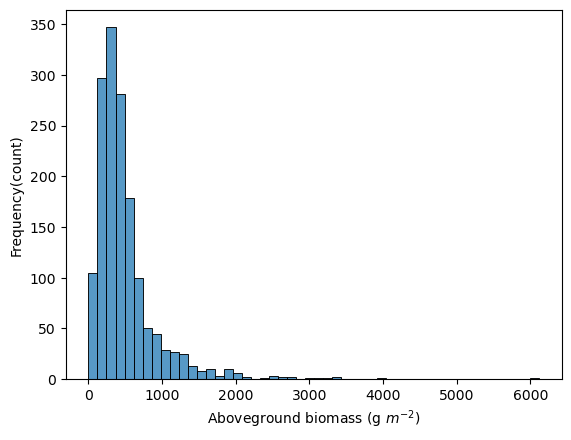

In [19]:
# df_final['Plant_Biomass'].hist(bins = 50) ##Note: Greatest biomass plots are not S. alterniflora - will be removed?

df_final['Plant_Biomass'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

#Hist plot
import seaborn as sn

g = sn.histplot(data = df_final, x = 'Plant_Biomass', bins = 50)
g.set(xlabel='Aboveground biomass (g $m^{-2}$)', ylabel='Frequency(count)')
g

# df_final

In [20]:
##Daymet - adding from previous extraction efforts
# dmdata = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/df_testxyzgridmet.csv') #OUTDATED
dmdata = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/daymetgridmet.csv')

# for col in dmdata.columns:
#     print(col)
    
# dmdata['Date'] = dmdata['Date_x']
# dmdata['Latitude'] = dmdata['Latitude_x']
# dmdata['Longitude'] = dmdata['Longitude_x']

dmx = dmdata[['Latitude','Longitude','Plant_Biomass','dayl','prcp','srad','swe','tmax','tmin','vp',
#               'dayl_rolling',
#               'prcp_rolling','srad_rolling','swe_rolling','tmax_rolling','tmin_rolling',
#               'vp_rolling',
              'dayl_daymMarMay','prcp_daymMarMay','srad_daymMarMay','swe_daymMarMay','tmax_daymMarMay',
              'tmin_daymMarMay','vp_daymMarMay','dayl_daymMayOct','prcp_daymMayOct','srad_daymMayOct','swe_daymMayOct',
              'tmax_daymMayOct','tmin_daymMayOct','vp_daymMayOct','dayl_Max','prcp_Max','srad_Max','swe_Max','tmax_Max',
              'tmin_Max','vp_Max','dayl_Min','prcp_Min','srad_Min','swe_Min','tmax_Min','tmin_Min','vp_Min','dayl_peak',
              'prcp_peak','srad_peak','swe_peak','tmax_peak','tmin_peak','vp_peak','eddi14d','eddi180d','eddi1y','eddi270d',
              'eddi2y','eddi30d','eddi5y','eddi90d','pdsi','spei14d','spei180d','spei1y','spei270d','spei2y','spei30d','spei5y',
              'spei90d','spi14d','spi180d','spi1y','spi270d','spi2y','spi30d','spi5y','spi90d','z','pdsi_MarMay',
              'spei180d_MarMay','spei1y_MarMay','spei30d_MarMay','spei5y_MarMay','spei90d_MarMay','pdsi_MayOct',
              'spei180d_MayOct','spei1y_MayOct','spei30d_MayOct','spei5y_MayOct','spei90d_MayOct','pdsi_Max','spei180d_Max',
              'spei1y_Max','spei30d_Max','spei5y_Max','spei90d_Max','pdsi_Min','spei180d_Min','spei1y_Min','spei30d_Min',
              'spei5y_Min','spei90d_Min','pdsi_gridmet','spei180d_gridmet','spei1y_gridmet','spei30d_gridmet','spei5y_gridmet',
              'spei90d_gridmet'
             ]]
dmx

df0 = df_final.copy()

dfdm = df0.merge(dmx, on = ['Latitude', 'Longitude', 'Plant_Biomass'], how='left')

# dfdm

In [21]:
##Modeling
df = df_final.copy()

##ADDING DAYMET
df = df_final.copy().merge(dmx, on = ['Latitude', 'Longitude', 'Plant_Biomass'], how='left') 
df['Yr'] = pd.to_datetime(df['Sampling_year'])

##LAGGING
df = df.sort_values(by=['Latitude', 'Longitude', 'Sampling_year'])
exclude_cols = ['Plant_Biomass', 'Sampling_year', 'Latitude', 'Longitude', 'elevation', 'Percent_flooding', 'LS_year', 'Yr']
cols_to_lag = [col for col in df.columns if col not in exclude_cols]

for var in cols_to_lag:
    df[f'{var}_lag1'] = df.groupby(['Latitude', 'Longitude'])[var].shift(1)
    
for var in cols_to_lag:
    df[f'{var}_lag2'] = df.groupby(['Latitude', 'Longitude'])[var].shift(2)

C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag1'] = df.groupby(['Latitude', 'Longitude'])[var].shift(1)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag1'] = df.groupby(['Latitude', 'Longitude'])[var].shift(1)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag1'] = df.groupby(['Latitude', 'Longitude'])[var].shift(1)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag1'] = df.groupby(['Latitude', 'Longitude'])[var].shift(1)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag2'] = df.groupby(['Latitude', 'Longitude'])[var].shift(2)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag2'] = df.groupby(['Latitude', 'Longitude'])[var].shift(2)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag2'] = df.groupby(['Latitude', 'Longitude'])[var].shift(2)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag2'] = df.groupby(['Latitude', 'Longitude'])[var].shift(2)
C:\Users\arj26323\AppData\Local\Temp\ipykernel_15776\3075780064.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [22]:
##Removing creek points that may have eroded over time (myproject2 in ArcGIS has some of the trend rasters and point locations)

cp = pd.read_csv('C:/Users/arj26323/OneDrive - University of Georgia/Documents/Data/Biomass datasets/Sapelo/creekpoints.csv')
cp2 = cp.drop_duplicates(subset=['Longitude', 'Latitude'])
cp3 = cp2[['Latitude', 'Longitude']]

df_cleaned = df.merge(cp3, on=['Latitude', 'Longitude'], how='left', indicator=True)
df_cleaned2 = df_cleaned[df_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

In [38]:
##FILTERS

df0 = df.copy()
df0['Sampling_year'] = df0['Sampling_year'].astype(str) #Needed after discharge merge

# df0 = pd.read_csv('C:/Users/arj26323/Documents/All extract/df0.csv') OLDDDDDDDDD

# df0 = df_cleaned2.copy() ##if you want to remove creek points

# df0 = df0[df0['Plant_Biomass'] < 5000] ##If you want to exclude outliers

# df0 = df0[df0['Sampling_year']<'2020-01-01'] ##Ignoring later data - use this for validation



'''REMOVE SITE if running all xargs'''


from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

# df1['ndvi_prcp_interaction'] = df1['ndvi'] * df1['prcp_daymMarMay']

# xargs=df0.loc[:, ~df0.columns.isin(['Latitude', 'Longitude', 'Sampling_year', 'LS_year', 'Plant_Biomass', 'Yr', 'Site'])]
##DOUBLECHECK ABOVE

yargs=df0['Plant_Biomass'] 

# xargs = df0[['elevation','nd_swir2_nir_median_01_12','nd_swir2_nir_median_05_10','nd_swir2_nir_mean_05_10','evi_mean_01_12',
#              'evi_max_05_10','nd_swir2_nir_median_08_10','srad_peak','nd_swir2_nir_mean_08_10','nd_swir2_nir_min_05_10',
#              'Percent_flooding','SWIR1_band_max_05_10','nd_r_g_mean_01_12','nd_swir2_nir_mean_01_12',
#              'nd_r_g_min_03_05','eddi2y','evi_mean_08_10','nd_swir2_nir_min_01_12','Red_band_mean_03_05','nd_g_b_mean_01_12',
#             'nd_swir2_nir_mean_01_12_lag1', 'nd_swir2_nir_median_05_10_lag1', 'evi_max_01_12', 'evi_median_01_12',
#             'Red_band_max_05_10', 'DSM']]


xargs = df0[['nd_swir2_nir_median_05_10','elevation','nd_swir2_nir_mean_05_10','Percent_flooding','srad_peak','evi_mean_08_10',
            'evi_max_05_10','nd_g_b_mean_01_12','evi_max_01_12','nd_swir2_nir_median_08_10','nd_swir2_r_min_05_10',
            'evi_mean_01_12','nd_g_b_median_01_12','Blue_band_max_05_10','nd_swir2_nir_median_01_12','NIR_band_max_03_05_lag2',
            'Red_band_max_05_10','dayl_daymMarMay','eddi2y','nd_swir2_nir_min_05_10','savi_mean_01_12', 
             'annual_discharge_cfs', 'annual_discharge_cfs_lag1', 'annual_discharge_cfs_lag2', 'apr_sep_avg_cfs',
             'apr_sep_avg_cfs_lag1', 'apr_sep_avg_cfs_lag2', 'nov_mar_avg_cfs', 'nov_mar_avg_cfs_lag1', 'nov_mar_avg_cfs_lag2',
            'slope', 'DSM', 'Latitude', 'Longitude','z_discharge','z_aprsep']] ##TAKE LAT/LON OUT?


size_x = 0.15
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test


'''LOG transform the river discharge data, and also calculate z scores'''

'LOG transform the river discharge data, and also calculate z scores'

In [39]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df0.isnull().sum())
    
# pd.reset_option('^display.', silent=True)
# for col in df0.columns:
#     print(col)

##If you want to extract df0 and load it as a df
# out_dir = os.path.expanduser('~/Downloads')
# out_csv = os.path.join(out_dir, 'df0.csv')

# df0.to_csv(out_csv)

In [40]:
#Pipeline:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

#Hyperparameters tuned later
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=1000, 
                                                                                min_samples_split=5, 
                                                                                min_samples_leaf=4,
                                                                                max_depth=20, random_state=seed))])

# ##DEFAULTS:
# pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, 
#                                                                                 min_samples_split=2, 
#                                                                                 min_samples_leaf=1,
#                                                                                 max_depth=None, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

# NDVI
print('NDVI BASELINE: around 0.2 r sq, RMSE 650')

Mean Absolute Error: 176.62224378293757
Mean Squared Error: 65241.073459203915
Root Mean Squared Error: 255.423322073776
The r squared is: 0.6430556460923376
0.6430556460923376
testing r2 is: 0.6430556460923376
training r2 is: 0.7939259801066134
NRMSE is: 0.08244227697874901
MEAN BASELINE:
Mean Absolute Error: 299.1868483476801
Root Mean Squared Error: 427.57048317692283
NDVI BASELINE: around 0.2 r sq, RMSE 650


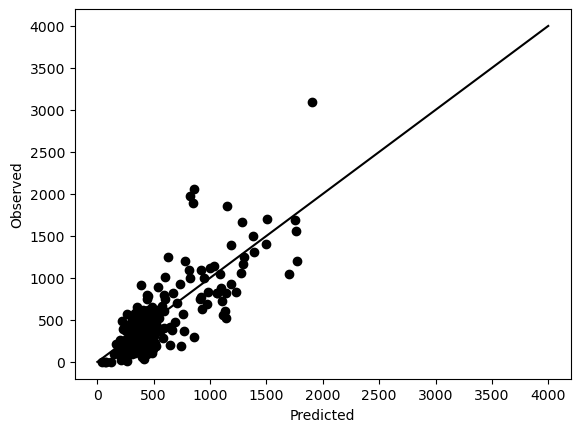

test data correlation coefficient is: 0.8046881255645623
train data correlation coefficient is: 0.9005951802706993


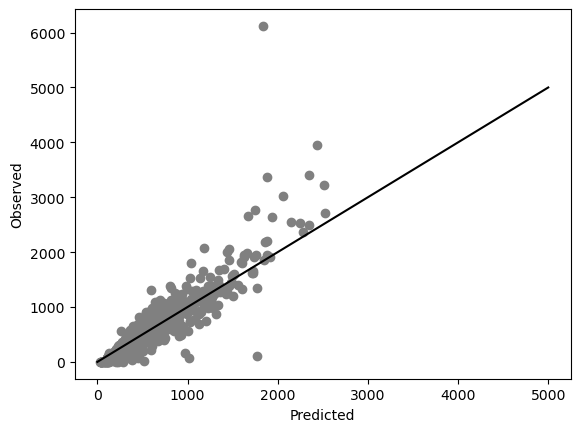

In [41]:
plt.scatter(y_pred, yargs_test, color = 'black') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 4000], [0, 4000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'gray')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [35]:
##k-fold cross validation; random forest

#Predictors below are based on feature selection - most important variables

predictors = xargs

targets = yargs

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate

X, y = predictors, targets
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

{'fit_time': array([18.42946243, 18.54751968, 18.5318296 , 18.86019206, 18.35155368,
        18.32801986, 18.27961516, 18.67211914, 18.03169537, 18.54727554]),
 'score_time': array([0.06235099, 0.06227326, 0.06239748, 0.04811502, 0.05421567,
        0.04686546, 0.04918838, 0.06248736, 0.04685092, 0.04684663]),
 'test_r2': array([0.64136874, 0.38275255, 0.71758066, 0.61512644, 0.6012355 ,
        0.63963512, 0.65428737, 0.50000382, 0.56365548, 0.64596068]),
 'test_neg_root_mean_squared_error': array([-227.51273111, -472.66134936, -227.82414429, -219.0526497 ,
        -299.61922405, -289.42255067, -209.37532735, -319.64807532,
        -309.86203277, -237.96675785])}

In [36]:
#Feature importance and average RMSE
x = pd.DataFrame(cv_results)
print(x['test_r2'].mean())
print(x['test_neg_root_mean_squared_error'].mean())
print('NRMSE is: ' + str(x['test_neg_root_mean_squared_error'].mean()/np.ptp(yargs_test)))

0.5961606374978117
-281.29448424605414
NRMSE is: -0.08363774668001114


In [345]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# X = xargs_train.copy().dropna()
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# print(vif_data)

# df_final

In [37]:
##Feature selection
import time
import numpy as np

feature_importances = pipe.named_steps['forest'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': xargs.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(21))  # Keep the top 20 most important features
xx = feature_importance_df.head(21)

# with(pd.set_option('display.max_rows', None) print(xx))

feature_importance_df

                      Feature  Importance
5              evi_mean_08_10    0.130843
4                   srad_peak    0.116111
3            Percent_flooding    0.089407
6               evi_max_05_10    0.083858
11             evi_mean_01_12    0.074501
19     nd_swir2_nir_min_05_10    0.054745
20            savi_mean_01_12    0.049568
8               evi_max_01_12    0.047228
1                   elevation    0.034555
12        nd_g_b_median_01_12    0.028237
18                     eddi2y    0.027097
7           nd_g_b_mean_01_12    0.025226
27            nov_mar_avg_cfs    0.024155
10       nd_swir2_r_min_05_10    0.021881
15    NIR_band_max_03_05_lag2    0.019711
9   nd_swir2_nir_median_08_10    0.017036
30                      slope    0.016998
31                        DSM    0.015405
13        Blue_band_max_05_10    0.015066
16         Red_band_max_05_10    0.014433
24            apr_sep_avg_cfs    0.014357


,Feature,Importance
5,evi_mean_08_10,0.130843
4,srad_peak,0.116111
3,Percent_flooding,0.089407
6,evi_max_05_10,0.083858
11,evi_mean_01_12,0.074501
19,nd_swir2_nir_min_05_10,0.054745
20,savi_mean_01_12,0.049568
8,evi_max_01_12,0.047228
1,elevation,0.034555
12,nd_g_b_median_01_12,0.028237


In [347]:
print(len(yargs))

##More work to do
# feature_importance_df

1569


In [348]:
# g = df0.plot(kind = 'scatter', x = 'Percent_flooding', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'nd_swir2_nir_mean_01_12', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'flats_min_03_05', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'elevation', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'thermal_band_celsius_median_01_12', y = 'Plant_Biomass')

# g

C:\Users\arj26323\AppData\Local\Temp\ipykernel_13384\1527095426.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfz['logannual'] = np.log(dfz['annual_discharge_cfs'])
C:\Users\arj26323\AppData\Local\Temp\ipykernel_13384\1527095426.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfz['z_discharge'] = stats.zscore(dfz['annual_discharge_cfs'])
C:\Users\arj26323\AppData\Local\Temp\ipykernel_13384\1527095426.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

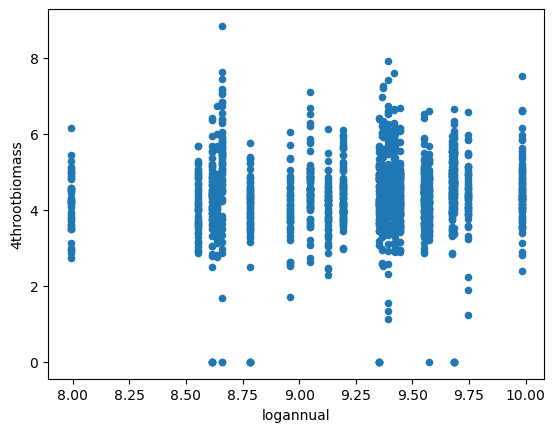

In [349]:
# g = df0.plot(kind = 'scatter', x = 'thermal_band_celsius_max_05_10', y = 'Plant_Biomass')

dfz = df0[['Plant_Biomass', 'Latitude','Longitude', 'Sampling_year', 'annual_discharge_cfs','apr_sep_avg_cfs','nov_mar_avg_cfs',
          'annual_discharge_cfs_lag1','apr_sep_avg_cfs_lag1','nov_mar_avg_cfs_lag1',
           'annual_discharge_cfs_lag2','apr_sep_avg_cfs_lag2','nov_mar_avg_cfs_lag2',
          'Site']]

dfz['logannual'] = np.log(dfz['annual_discharge_cfs'])

from scipy import stats
dfz['z_discharge'] = stats.zscore(dfz['annual_discharge_cfs'])
dfz['z_aprsep'] = stats.zscore(dfz['apr_sep_avg_cfs'])

dfz['4throotbiomass'] = np.sqrt(np.sqrt(dfz['Plant_Biomass']))

grouped = dfz.groupby(['Site'])

# # Loop through each group and plot the discharge trend
# for (site), group in grouped:
#     plt.figure(figsize=(8, 4))
#     plt.plot(group['z_discharge'], group['4throotbiomass'], marker='o', linestyle='')
#     plt.title(f'Discharge Trend at Site {site}')
#     plt.xlabel('Annual Discharge (cfs)')
#     plt.ylabel('Plant_Biomass^0.25')
#     plt.grid(False)
#     plt.tight_layout()
#     plt.show()

# g = df0.plot(kind = 'scatter', x = 'annual_discharge_cfs', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'apr_sep_avg_cfs', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'nov_mar_avg_cfs', y = 'Plant_Biomass')

# g = df0.plot(kind = 'scatter', x = 'annual_discharge_cfs_lag1', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'apr_sep_avg_cfs_lag1', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'nov_mar_avg_cfs_lag1', y = 'Plant_Biomass')

# g = df0.plot(kind = 'scatter', x = 'annual_discharge_cfs_lag2', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'apr_sep_avg_cfs_lag2', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'nov_mar_avg_cfs_lag2', y = 'Plant_Biomass')

# g = df0.plot(kind = 'scatter', x = 'apr_sep_avg_cfs', y = 'Plant_Biomass')
# g = df0.plot(kind = 'scatter', x = 'nov_mar_avg_cfs', y = 'Plant_Biomass')


# g = dfz.plot(kind = 'scatter', x = 'z_discharge', y = 'Plant_Biomass')

df8 = dfz[dfz['Site'] == 8]

g = dfz.plot(kind = 'scatter', x = 'logannual', y = '4throotbiomass')

# g

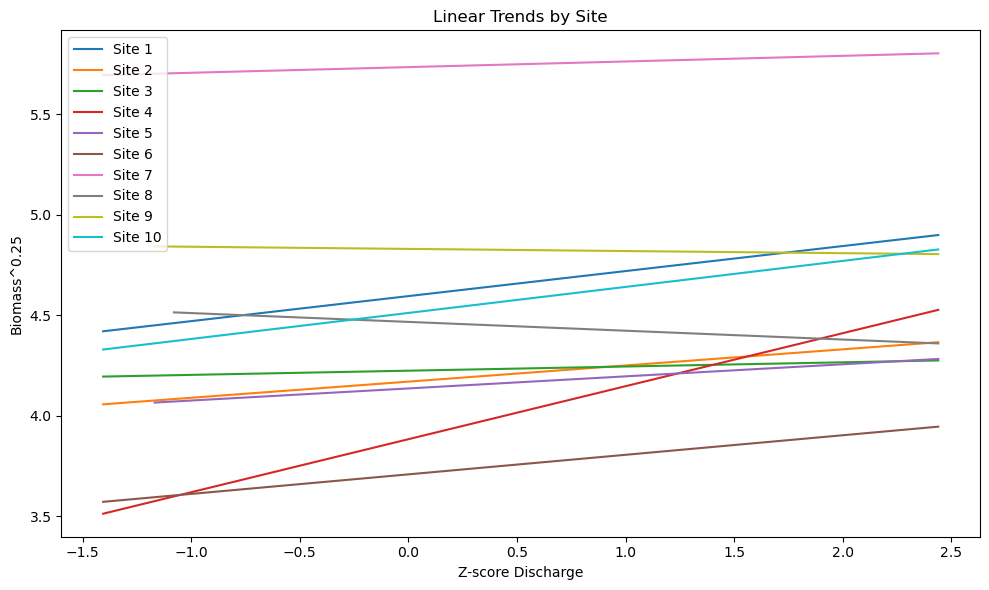

Site 1: slope = 0.1246, r2 = 0.0387, p = 0.0272
Site 2: slope = 0.0803, r2 = 0.0183, p = 0.0700
Site 3: slope = 0.0208, r2 = 0.0009, p = 0.6894
Site 4: slope = 0.2638, r2 = 0.1017, p = 0.0000
Site 5: slope = 0.0601, r2 = 0.0130, p = 0.1666
Site 6: slope = 0.0973, r2 = 0.0054, p = 0.3116
Site 7: slope = 0.0281, r2 = 0.0017, p = 0.5950
Site 8: slope = -0.0439, r2 = 0.0019, p = 0.6672
Site 9: slope = -0.0106, r2 = 0.0002, p = 0.8765
Site 10: slope = 0.1295, r2 = 0.0262, p = 0.0433


In [350]:
import numpy as np
from scipy.stats import linregress

plt.figure(figsize=(10, 6))

# Optional: collect regression stats in a list
regression_results = []

for site, group in dfz.groupby('Site'):
    x = group['z_aprsep']
    y = group['4throotbiomass']
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Save stats
    regression_results.append({
        'site': site,
        'slope': slope,
        'r2_value': r_value ** 2,
        'p_value': p_value
    })
    
    #     # Scatter points (optional)
# #     plt.scatter(x, y, label=f'Site {site}', alpha=0.5)
    
    # Plot line
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, label=f'Site {site}')

plt.xlabel('Z-score Discharge')
plt.ylabel('Biomass^0.25')
plt.title('Linear Trends by Site')
plt.legend()
plt.tight_layout()
plt.show()

# Print regression results
for result in regression_results:
    print(f"Site {result['site']}: slope = {result['slope']:.4f}, r2 = {result['r2_value']:.4f}, p = {result['p_value']:.4f}")

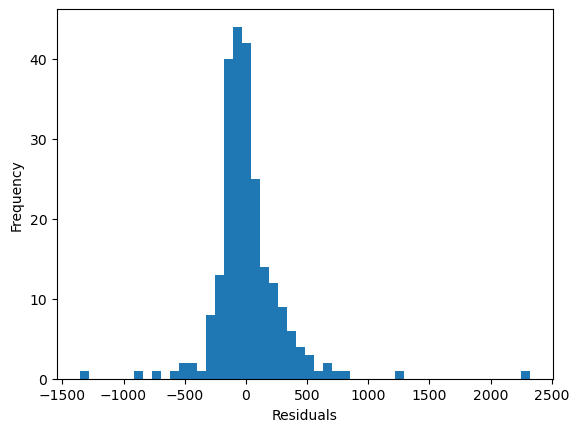

In [351]:
import matplotlib.pyplot as plt
residuals = yargs_test - y_pred
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# plt.scatter(yargs_test, y_pred)
# plt.xlabel("Actual Biomass")
# plt.ylabel("Predicted Biomass")
# plt.plot([min(yargs_test), max(yargs_test)], [min(yargs_test), max(yargs_test)], 'r--')
# plt.show()

In [179]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'forest__n_estimators': [50, 100, 200, 300, 500, 1000],
#     'forest__max_depth': [10, 20, 30, None],
#     'forest__min_samples_split': [2, 5, 10],
#     'forest__min_samples_leaf': [1, 2, 4]
# }

# rf_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=seed)
# rf_search.fit(xargs_train, yargs_train)

# print("Best Params:", rf_search.best_params_)
# pipe = rf_search.best_estimator_

In [35]:
import os
# os.chdir('C:\\Users\\arj26323\\Documents\\Data')
os.getcwd()

# from joblib import dump

# # Save the whole pipeline (including preprocessing and model)
# dump(pipe, 'rf_pipeline.joblib')

'C:\\Users\\arj26323\\PhD\\Jupyter\\LTER sites\\Georgia'

In [ ]:
#Finito